## Using Machine Learning to determine the drivers of housing prices during a stagnant market (current property market)
Book # 6

- Explore the dataset
- Train & test
- Perform Regression model
- Extract information for coefficients

**Goal : Identify what are the Sale Price drivers in our current property market**

Note: full address was kept within the dataset for prediction, but was removed from the coef list since it gave too much noise for coef interpretation. 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'input/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# packages to import

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_importance,XGBClassifier,XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import r2_score

from scipy.stats import skew

In [ ]:
file_path = '/content/gdrive/My Drive/resale-flat-prices/'
print(file_path)

/content/gdrive/My Drive/resale-flat-prices/


In [ ]:
# importing dataframes

df_const = pd.read_csv(file_path + 'df_const_p4.csv')


###**Central Area Housing Prices & Drivers During our current property market**

In [ ]:
# Central Area 

df_central = df_const[df_const['region'] == 'Central']

Skew is:  0.29239304572829156


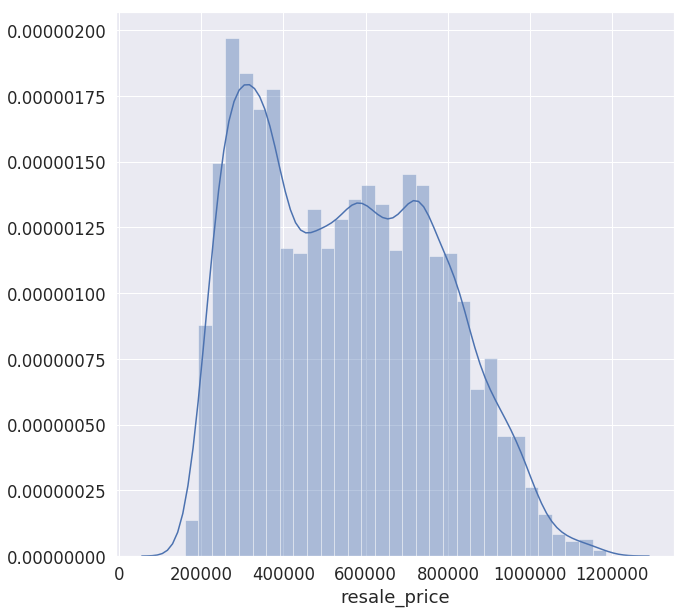

In [ ]:
# Target 
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.distplot(df_central['resale_price'])
print('Skew is: ',skew(df_central['resale_price']))

**Bimodal housing prices , try per square feet**

Skew is:  0.584474437278375


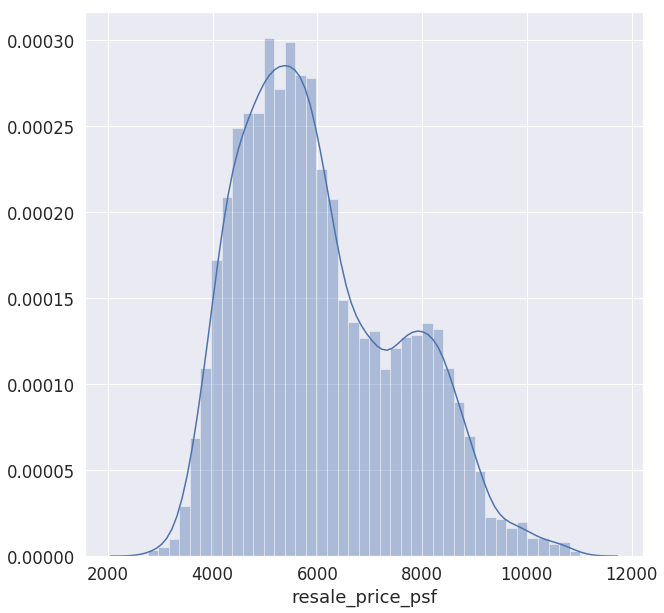

In [ ]:
# Target : Resale Price per sqaure foot 
sns.distplot(df_central['resale_price_psf'])
print('Skew is: ',skew(df_central['resale_price_psf']))

**Not much better, but it may be due to some locations in central area.**

In [ ]:
cat_features = ['town', 'flat_type', 'storey_range', 'flat_model',
                'full_address', 'nearest_mrt','nearest_school']
       
num_features = ['lease_commence_date', 'remaining_lease', 'max_floor_lvl','total_dwelling_units' ,'1room_sold', '2room_sold','3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
        'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental','other_room_rental', 'Latitude', 'Longitude',
       'nearest_distance','nearest_distance_school', 'Ranking', 'Tot_Vacancy','perc_balance_vacancy', 'Month']

dum_features = ['residential','commercial', 'market_hawker', 'miscellaneous', 'multistorey_carpark',
       'precinct_pavilion', 'is_interchange']



# Transforming the data into a new proper dataframe
def creating_dataframe(df):

  
  # Get dummified values
  dummies = pd.get_dummies(df[cat_features], drop_first = True)
  print('Added Columns from Dummies :', dummies.shape[1])
  dummies.reset_index(drop = True, inplace = True)
  
  #Dummies Dataframe
  df.reset_index(drop = True, inplace = True)
  dummies = pd.concat([dummies, df[dum_features]], axis = 1)
  
  # Standard Scaling 
  std = StandardScaler()
  num_std = pd.DataFrame(std.fit_transform(df[num_features]))
  num_std.columns = num_features
  num_std.reset_index(drop = True, inplace = True)
  
  X = pd.concat([num_std, dummies], axis = 1)
  print('Total Number of Columns :', X.shape[1])
  print('Total Number of Rows :', X.shape[0])
  
  df = pd.concat([df[['resale_price_psf']],X], axis = 1)
  
  return df



  
# To get the scaler only 
def std_scaler(df):
  num_features = ['lease_commence_date', 'remaining_lease', 'max_floor_lvl','total_dwelling_units' ,'1room_sold', '2room_sold','3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
        'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental','other_room_rental', 'Latitude', 'Longitude',
       'nearest_distance','nearest_distance_school', 'Ranking', 'Tot_Vacancy','perc_balance_vacancy', 'Month']
  
  # Standard Scaling 
  std = StandardScaler()
  std = std.fit(df[num_features])
  
  return std
  

In [ ]:
new_central_df = creating_dataframe(df_central)

Added Columns from Dummies : 1647
Total Number of Columns : 1678
Total Number of Rows : 10689


In [ ]:
# Define y (target) as the resale price per square foot
X = new_central_df.drop(columns = ['resale_price_psf'])
y = new_central_df['resale_price_psf']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.91770912 0.91177599 0.91585806]
0.915114389107852
1.0


In [ ]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.9184130089912651


**Extract coefficients to see dolar values**
Note: coefficients need to be transformed using the standard scaler to derive the monetary value.

In [ ]:
std = std_scaler(df_central)

In [ ]:
def coef_dataframe(X):
  conversion_of_coef_list =[tuple(ridge.coef_)]
  coefs = pd.DataFrame(conversion_of_coef_list, columns = X.columns, index = ['Dollar Value ($)'])

  # Reversing the Standardardization of the numerical stardardized values
  # Standard Scaling 
  coefs[num_features] = std.transform(coefs[num_features])
  
  # new DataFrame with the coefficients 
  dollar_values = pd.DataFrame(X.columns, columns = ['Driver'])
  dollar_values['Dollar Value per Sqft'] = coefs.values.tolist()[0]
  dollar_values = dollar_values[~dollar_values.Driver.str.contains("full_address")]
  
  return dollar_values

In [ ]:
dollar_values_central = coef_dataframe(X)

In [ ]:
print('Top 20 Positive Drivers today in the Central Area')
dollar_values_central.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers today in the Central Area


,Driver,Dollar Value per Sqft
17,Longitude,4922.309507
53,flat_model_terrace,3090.059284
41,storey_range_40-50,1306.625588
40,storey_range_30-40,1064.493011
29,town_MARINE PARADE,1019.440603
1636,nearest_school_ Cantonment Primary School,881.010198
1596,nearest_mrt_BRAS BASAH MRT STATION SINGAPORE,842.686094
39,storey_range_20-30,727.089782
1627,nearest_mrt_TANJONG PAGAR MRT STATION SINGAPORE,698.325339
1590,nearest_mrt_ANG MO KIO MRT STATION SINGAPORE,641.280400


In [ ]:
print('Top 20 Negative Drivers today in the Central Area')
dollar_values_central.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(20)

Top 20 Negative Drivers today in the Central Area


,Driver,Dollar Value per Sqft
16,Latitude,-6464.759013
1613,nearest_mrt_LITTLE INDIA MRT STATION SINGAPORE,-1151.603326
18,nearest_distance,-957.725335
1654,nearest_school_ Maha Bodhi School,-880.723542
28,town_KALLANG/WHAMPOA,-727.893597
1646,nearest_school_ Geylang Methodist School (Prim...,-632.177816
31,town_TOA PAYOH,-595.601508
1610,nearest_mrt_KEMBANGAN MRT STATION SINGAPORE,-577.588255
27,town_GEYLANG,-550.904334
1673,market_hawker,-549.719422


###**Major Positive Driver of Prices in the Central Area During our current property market**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

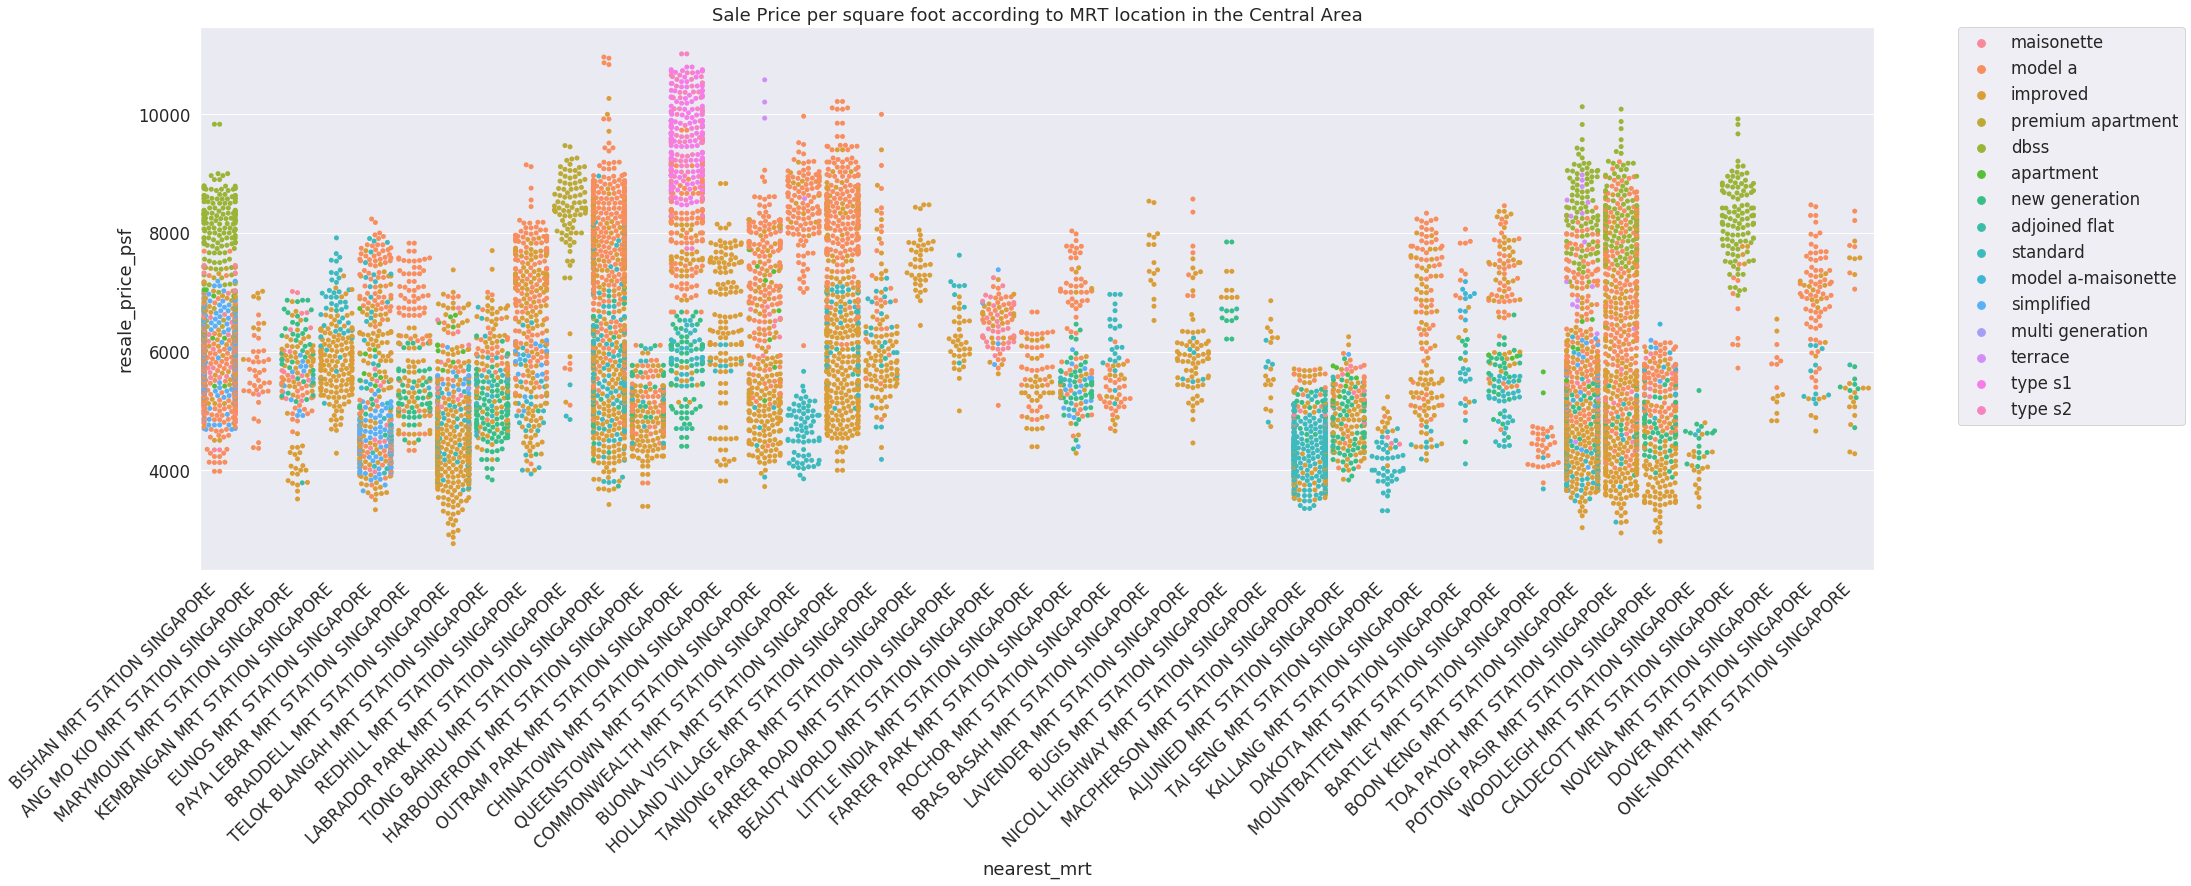

In [ ]:
sns.set(rc={'figure.figsize':(30,10)},  font_scale=1.5)
sns.swarmplot(x = 'nearest_mrt', y = 'resale_price_psf', data = df_central, hue = 'flat_model')
plt.title('Sale Price per square foot according to MRT location in the Central Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45, ha='right')

No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

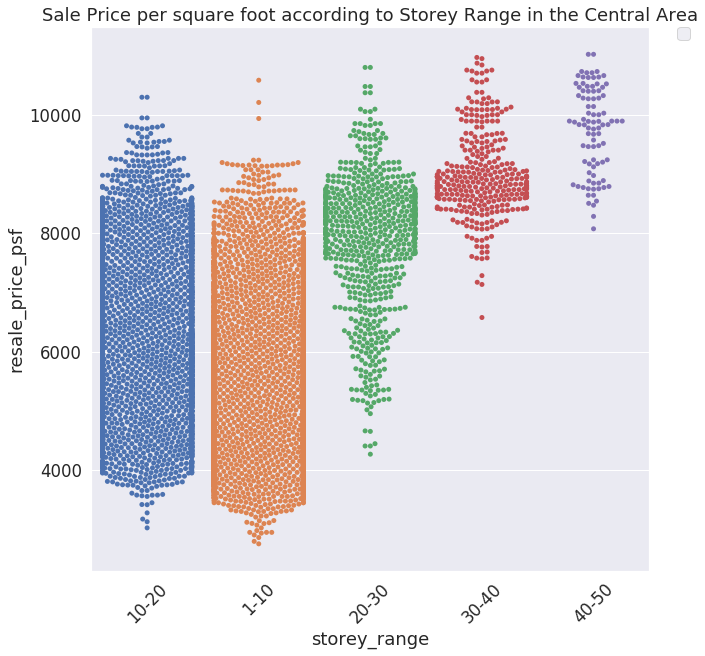

In [ ]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.swarmplot(x = 'storey_range', y = 'resale_price_psf', data = df_central)
plt.title('Sale Price per square foot according to Storey Range in the Central Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45, ha='center')

###**Eastern Area Housing Prices & Drivers During our current property market**

In [ ]:
# Eastern Area of Singapore 

df_east = df_const[df_const['region'] == 'East']

Skew is:  0.6616029679677204


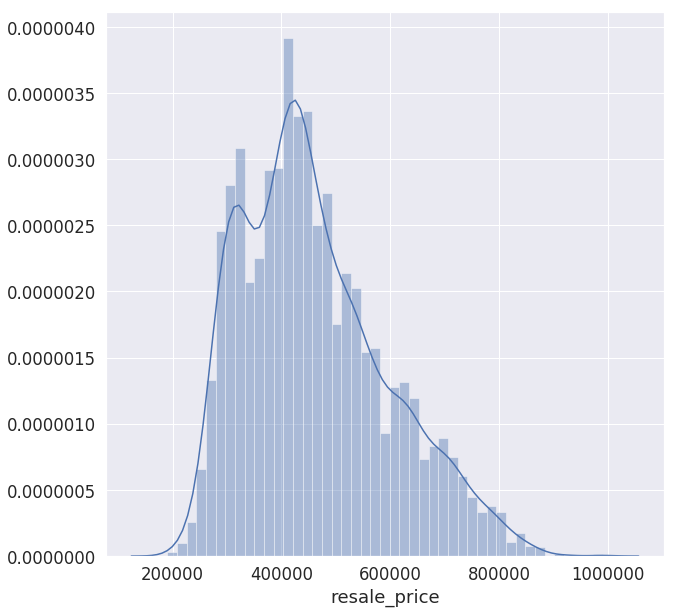

In [ ]:
# Target 
sns.distplot(df_east['resale_price'])
print('Skew is: ',skew(df_east['resale_price']))

**Skewed sale price.**

Skew is:  1.7153750154836653


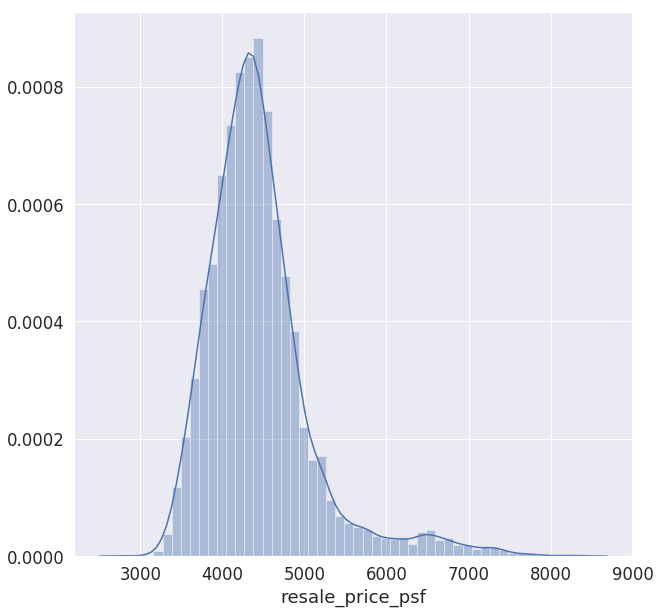

In [ ]:
# Target : Resale Price per sqaure foot 
sns.distplot(df_east['resale_price_psf'])
print('Skew is: ',skew(df_east['resale_price_psf']))

**The skew is very high ... see how the model performs and then decide ...**

In [ ]:
new_eastern_df = creating_dataframe(df_east)

Added Columns from Dummies : 1567
Total Number of Columns : 1598
Total Number of Rows : 8295


In [ ]:
# Define y (target) as the resale price per square foot
X = new_eastern_df.drop(columns = ['resale_price_psf'])
y = new_eastern_df['resale_price_psf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.8172349  0.81120752 0.83647765]
0.8216400243726252
1.0


In [ ]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.8378179455378318


In [ ]:
std = std_scaler(df_east)
dollar_values_eastern = coef_dataframe(X)

In [ ]:
print('Top 20 Positive Drivers in current market the Eastern Area')
dollar_values_eastern.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers in current market the Eastern Area


,Driver,Dollar Value per Sqft
1556,nearest_mrt_CHANGI AIRPORT MRT STATION SINGAPORE,775.208133
32,storey_range_20-30,755.887442
34,flat_model_dbss,642.803939
1570,nearest_school_ Eunos Primary School,632.399753
1583,nearest_school_ St. Stephen’s School,326.416616
19,nearest_distance_school,270.532773
1585,nearest_school_ Tampines Primary School,270.051858
31,storey_range_10-20,226.797774
1557,nearest_mrt_EUNOS MRT STATION SINGAPORE,194.224976
1590,nearest_school_ Yumin Primary School,162.562783


In [ ]:
print('Top 10 Negative Drivers in current market in the Eastern Area')
dollar_values_eastern.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 10 Negative Drivers in current market in the Eastern Area


,Driver,Dollar Value per Sqft
16,Latitude,-3957.182561
17,Longitude,-3646.818630
1559,nearest_mrt_PASIR RIS MRT STATION SINGAPORE,-647.262953
18,nearest_distance,-601.521370
27,flat_type_4 ROOM,-490.629470
1560,nearest_mrt_SIMEI MRT STATION SINGAPORE,-428.895435
28,flat_type_5 ROOM,-428.501057
37,flat_model_model a,-325.029879
1576,nearest_school_ Opera Estate Primary School,-324.127420
35,flat_model_improved,-297.176791


###**Major Negative Driver of Prices in the Eastern Area During our current property market**

No handles with labels found to put in legend.


(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <a list of 10 Text xticklabel objects>)

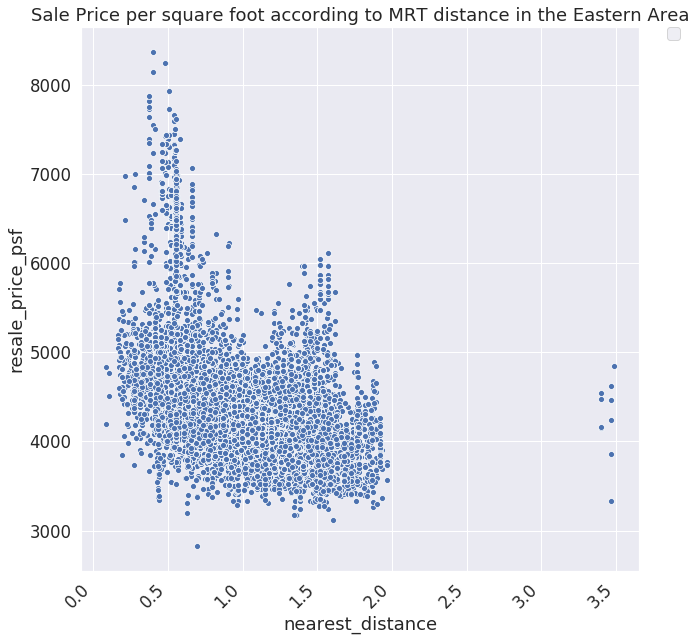

In [ ]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.scatterplot(x = 'nearest_distance', y = 'resale_price_psf', data = df_east)
plt.title('Sale Price per square foot according to MRT distance in the Eastern Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45, ha='right')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

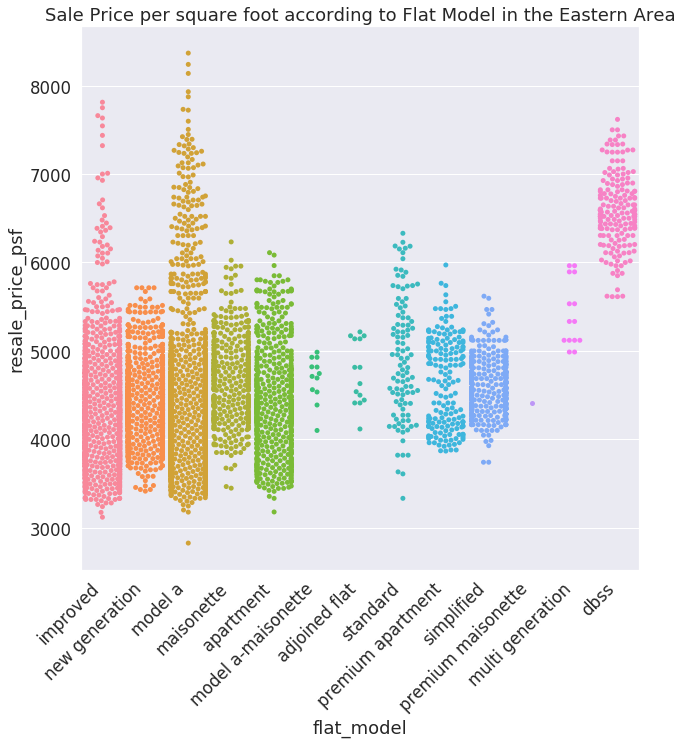

In [ ]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.swarmplot(x = 'flat_model', y = 'resale_price_psf', data = df_east)
plt.title('Sale Price per square foot according to Flat Model in the Eastern Area')
plt.xticks(rotation = 45, ha = 'right')

###**Western Area Housing Prices & Drivers During our current property market**

In [ ]:
# Western area of Singapore
df_west = df_const[df_const['region'] == 'West']

Skew is:  1.0703298321432078


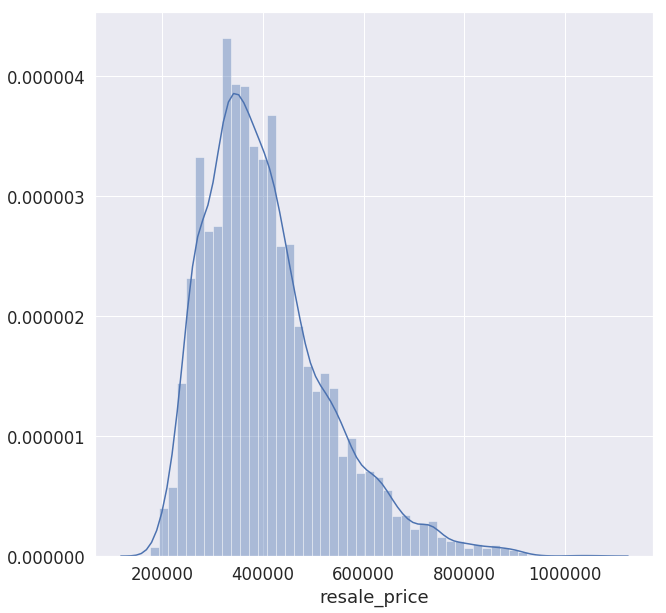

In [ ]:
# Target 
sns.distplot(df_west['resale_price'])
print('Skew is: ',skew(df_west['resale_price']))

**The distribution of prices is skewed**

Skew is:  1.7518874328825411


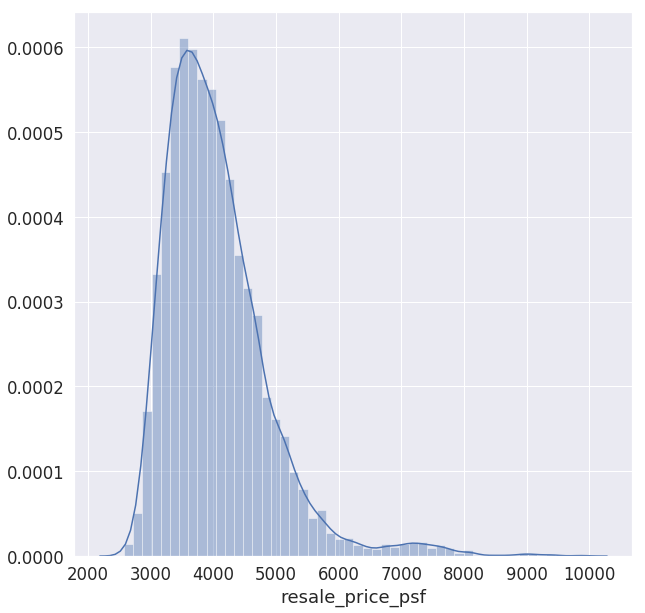

In [ ]:
# Target 
sns.distplot(df_west['resale_price_psf'])
print('Skew is: ',skew(df_west['resale_price_psf']))

**The distribution of prices is even more skewed ... see how it runs and maybe change the target for east and west**

In [ ]:
new_west_df = creating_dataframe(df_west)

Added Columns from Dummies : 2139
Total Number of Columns : 2170
Total Number of Rows : 11249


In [ ]:
# Define y (target) as the resale price per square foot
X = new_west_df.drop(columns = ['resale_price_psf'])
y = new_west_df['resale_price_psf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.88867718 0.88486498 0.89410575]
0.8892159726377485
1.0


In [ ]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.8928109338288573


In [ ]:
std = std_scaler(df_west)
dollar_values_west = coef_dataframe(X)

In [ ]:
print('Top 20 Positive Drivers our current market in the Western Area')
dollar_values_west.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers our current market in the Western Area


,Driver,Dollar Value per Sqft
17,Longitude,7259.333783
35,storey_range_30-40,783.668718
36,storey_range_40-50,582.965360
26,town_CLEMENTI,508.103199
27,town_JURONG EAST,476.583764
34,storey_range_20-30,468.270971
2145,nearest_school_ Pei Tong Primary School,463.906227
2153,nearest_school_ Teck Whye Primary School,339.801030
2129,nearest_school_ Clementi Primary School,331.902761
2139,nearest_school_ Juying Primary School,330.946903


In [ ]:
print('Top 10 Negative Drivers in our current market in the Western Area')
dollar_values_west.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 10 Negative Drivers in our current market in the Western Area


,Driver,Dollar Value per Sqft
16,Latitude,-1967.663476
18,nearest_distance,-792.660401
25,town_CHOA CHU KANG,-563.083841
2114,nearest_mrt_BUKIT GOMBAK MRT STATION SINGAPORE,-361.056830
47,flat_model_standard,-359.313715
45,flat_model_premium maisonette,-319.627414
31,flat_type_5 ROOM,-311.197964
40,flat_model_model a,-304.416183
2142,nearest_school_ Lakeside Primary School,-289.948912
0,lease_commence_date,-267.995494


###**Major Negative Driver of Prices in the West Area During our current property market**

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

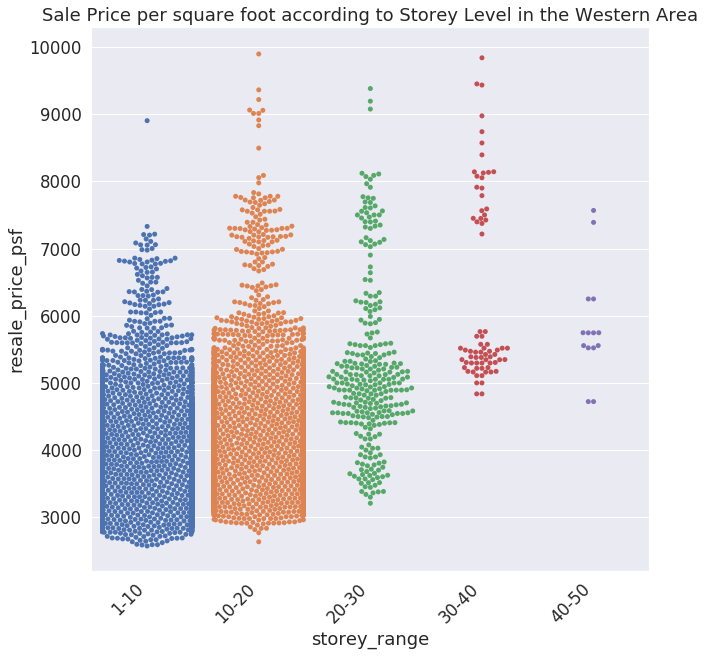

In [ ]:

sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.swarmplot(x = 'storey_range', y = 'resale_price_psf', data = df_west)
plt.title('Sale Price per square foot according to Storey Level in the Western Area')
plt.xticks(rotation = 45, ha = 'right')

(array([1.28, 1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42]),
 <a list of 8 Text xticklabel objects>)

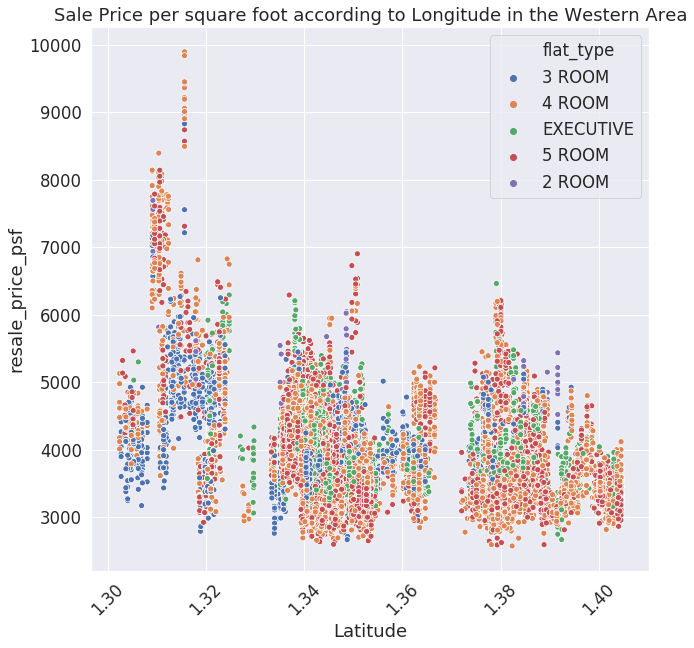

In [ ]:

sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.scatterplot(x = 'Latitude', y = 'resale_price_psf', data = df_west, hue = 'flat_type')
plt.title('Sale Price per square foot according to Longitude in the Western Area')

plt.xticks(rotation = 45)

###**Northern Area Housing Prices & Drivers During our current property market**

In [ ]:
# Northern area of Singapore
df_north = df_const[df_const['region'] == 'North']

Skew is:  1.1978929478393752


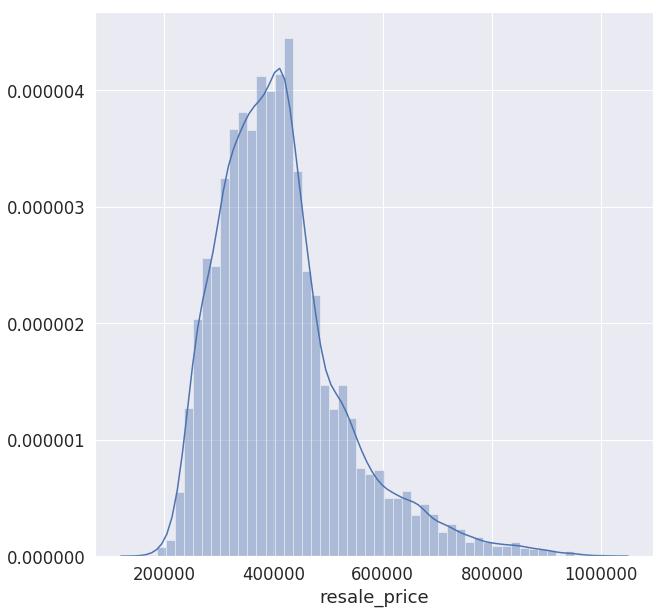

In [ ]:
# Target 
sns.distplot(df_north['resale_price'])
print('Skew is: ',skew(df_north['resale_price']))

**Skewed Data**

Skew is:  1.2512018052453528


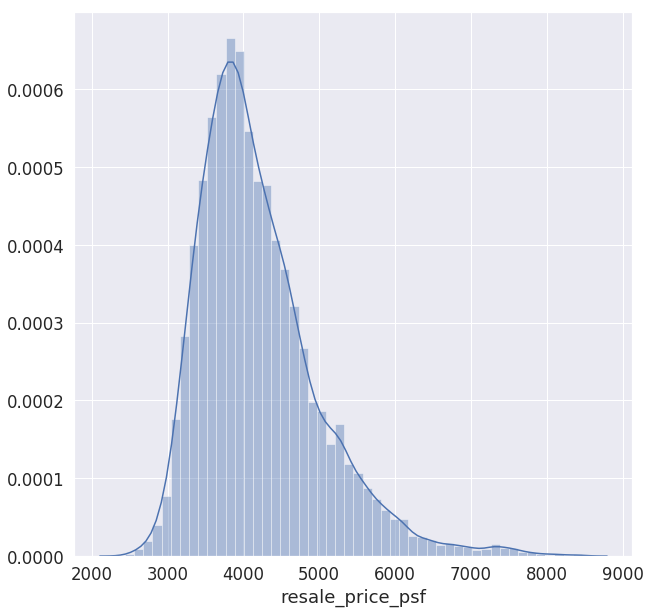

In [ ]:
# Target 
sns.distplot(df_north['resale_price_psf'])
print('Skew is: ',skew(df_north['resale_price_psf']))

**No Change**

In [ ]:
new_north_df = creating_dataframe(df_north)

Added Columns from Dummies : 3263
Total Number of Columns : 3294
Total Number of Rows : 19470


In [ ]:
# Define y (target) as the resale price per square foot
X = new_north_df.drop(columns = ['resale_price_psf'])
y = new_north_df['resale_price_psf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.8702922  0.87137915 0.86224583]
0.8679723912638605
1.0


In [ ]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.8764611094827228


In [ ]:
std = std_scaler(df_north)
dollar_values_northern = coef_dataframe(X)

In [ ]:
print('Top 20 Positive Drivers our current market the Northen Area')
dollar_values_northern.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers our current market the Northen Area


,Driver,Dollar Value per Sqft
39,flat_model_dbss,729.387382
41,flat_model_improved-maisonette,555.624310
3260,nearest_school_ Punggol Cove Primary School,510.168238
3204,nearest_mrt_ANG MO KIO MRT STATION SINGAPORE,505.059148
37,storey_range_20-30,482.668205
28,town_SERANGOON,442.171085
3283,nearest_school_ Yangzheng Primary School,381.117807
3223,nearest_school_ CHIJ St. Nicholas Girls’ School,333.875759
25,town_PUNGGOL,318.312116
44,flat_model_model a-maisonette,315.341602


In [ ]:
print('Top 10 Negative Drivers in our current market in the Northern Area')
dollar_values_northern.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 10 Negative Drivers in our current market in the Northern Area


,Driver,Dollar Value per Sqft
17,Longitude,-13169.662315
16,Latitude,-12521.837108
29,town_WOODLANDS,-977.469747
33,flat_type_5 ROOM,-872.461147
32,flat_type_4 ROOM,-767.050163
34,flat_type_EXECUTIVE,-657.237217
18,nearest_distance,-601.057055
43,flat_model_model a,-586.590089
31,flat_type_3 ROOM,-547.496635
47,flat_model_new generation,-542.042405


###**Major Negative Driver of Prices in the Northern Area During our current property market**

(array([1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48]),
 <a list of 8 Text xticklabel objects>)

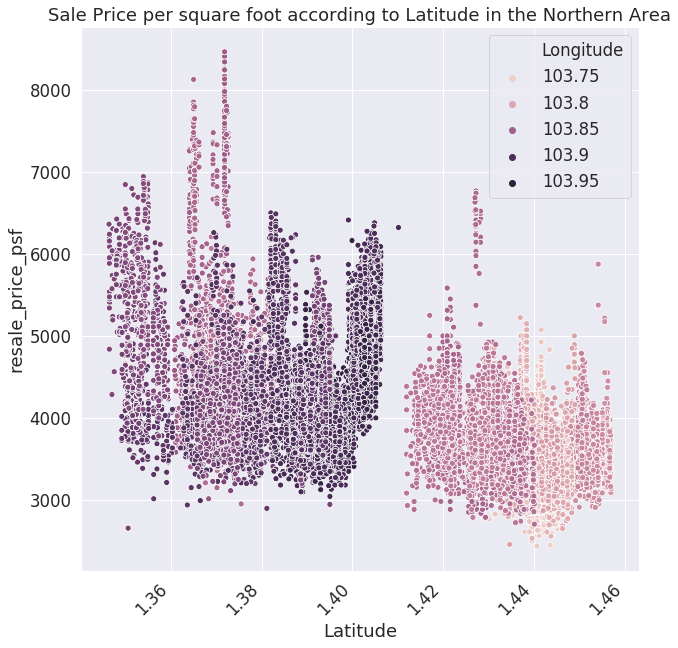

In [ ]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.scatterplot(x = 'Latitude', y = 'resale_price_psf', data = df_north, hue = 'Longitude')
plt.title('Sale Price per square foot according to Latitude in the Northern Area')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45, ha='right')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

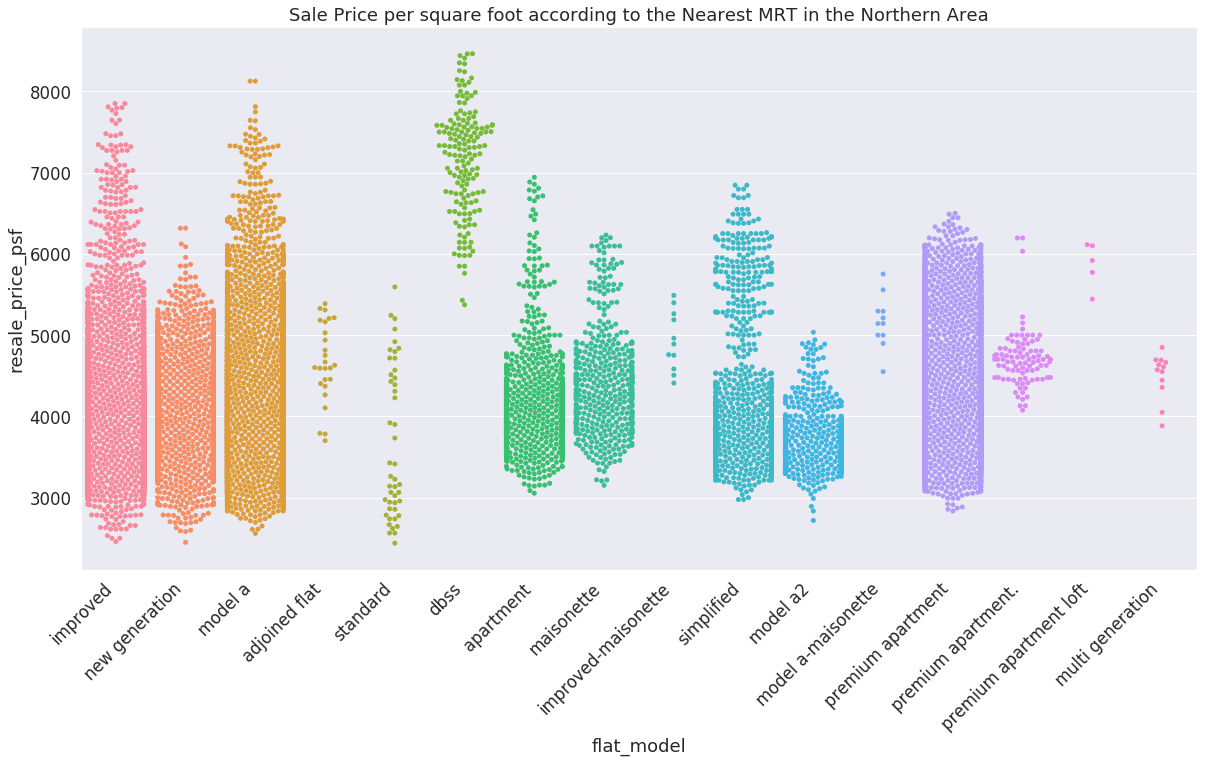

In [ ]:
sns.set(rc={'figure.figsize':(20,10)},  font_scale=1.5)
sns.swarmplot(x = 'flat_model', y = 'resale_price_psf', data = df_north)
plt.title('Sale Price per square foot according to the Flat Model in the Northern Area')
plt.xticks(rotation = 45, ha='right')

###**Conclusion**

**Drivers of the Property Market in our current property market**

**The higher the better, can I live downtown or close to an MRT?**

- Closeness to new MRT stations
- DBSS flats are much more expensive
- Closeness to Schools
- Closeness to the Central Area


Note: Compare to the previous models/ sqft is not normally distributed and quite skewed, meaning that many small houses are selling at a higher price of vice versa. This could be due to the fact that people are ok with living in smaller units, as long as they have access to schools, mrts or they are in the central area. Also, higher floors means more fresh air & breeze due to the high amount of flats. It is therefore maybe even more attractive now than it was before. 


In [ ]:
print('Mean Home Price in the Central Area: ', int(df_central['resale_price'].mean()), '// Price Per Sqft:',int(df_central['resale_price_psf'].mean()))
print('Mean Home Price in the Eastern Area: ', int(df_east['resale_price'].mean()), '// Price Per Sqft:',int(df_east['resale_price_psf'].mean()))
print('Mean Home Price in the Western Area: ', int(df_west['resale_price'].mean()), '// Price Per Sqft:',int(df_west['resale_price_psf'].mean()))
print('Mean Home Price in the Northern Area: ', int(df_north['resale_price'].mean()), '// Price Per Sqft:',int(df_north['resale_price_psf'].mean()))


Mean Home Price in the Central Area:  548230 // Price Per Sqft: 6046
Mean Home Price in the Eastern Area:  460538 // Price Per Sqft: 4446
Mean Home Price in the Western Area:  405567 // Price Per Sqft: 4050
Mean Home Price in the Northern Area:  412850 // Price Per Sqft: 4201
